## Imports

In [ ]:
from langgraph.graph import StateGraph, START, END

from langchain_groq.chat_models import ChatGroq
from pydantic import BaseModel, Field

from typing import TypedDict, Annotated
import operator # python function for operators
from dotenv import load_dotenv
load_dotenv()

True

## Simple Parallel Workflow

In [6]:
class BatterState(TypedDict):
    runs: int
    balls: int
    num_4s: int
    num_6s: int
    
    strike_rate: float
    boundary_pct: float
    balls_per_boundary: float
    summary: str

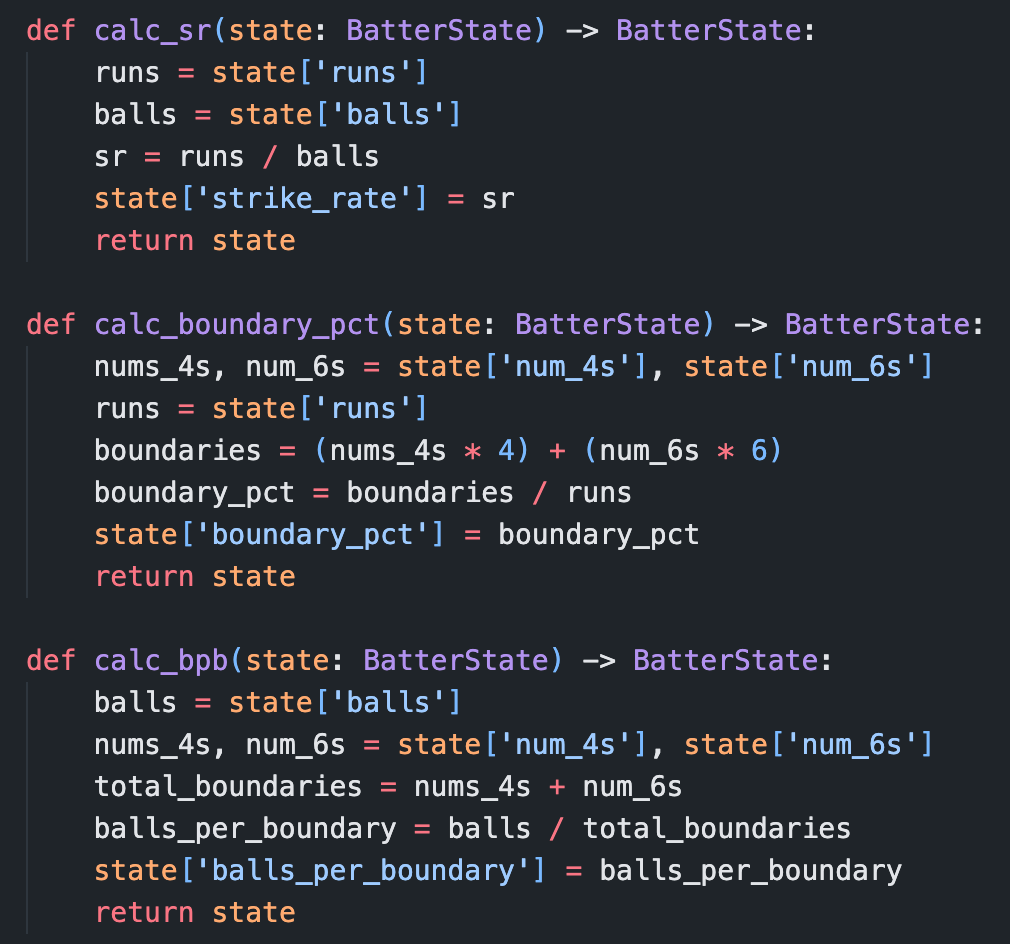

+ If a node returns the whole state, LangGraph treats EVERY key in that return as an update — even if the value didn’t change.  
+ In parallel workflow, above, though I am not changing the `runs` or `nums_4s`, `nums_6s` key, I am returning the full state, and that is considered as an update (an identity update xd).

As a safe side, **always perform the partial update**.

In [17]:
def calc_sr(state: BatterState) -> BatterState:
    runs = state['runs']
    balls = state['balls']
    sr = (runs / balls) * 100
    # state['strike_rate'] = sr
    # return state # do not return the full state
    return {'strike_rate': round(sr, 2)}  # return only the computed/updated value [Partial Update]

def calc_boundary_pct(state: BatterState) -> BatterState:
    nums_4s, num_6s = state['num_4s'], state['num_6s']
    runs = state['runs']
    boundaries = (nums_4s * 4) + (num_6s * 6)
    boundary_pct = (boundaries / runs) * 100
    # state['boundary_pct'] = boundary_pct
    # return state
    return {'boundary_pct': round(boundary_pct, 2)}

def calc_bpb(state: BatterState) -> BatterState:
    balls = state['balls']
    nums_4s, num_6s = state['num_4s'], state['num_6s']
    total_boundaries = nums_4s + num_6s
    balls_per_boundary = balls / total_boundaries
    # state['balls_per_boundary'] = balls_per_boundary
    # return state
    return {'balls_per_boundary': round(balls_per_boundary, 2)}

def summarize_stats(state: BatterState) -> BatterState:
    summary = f"""
    Strike Rate: {state['strike_rate']}
    Boundary Percentage: {state['boundary_pct']}
    Balls per Boundary: {state['balls_per_boundary']} """
    # state['summary'] = summary
    # return state
    return {'summary': summary}
    

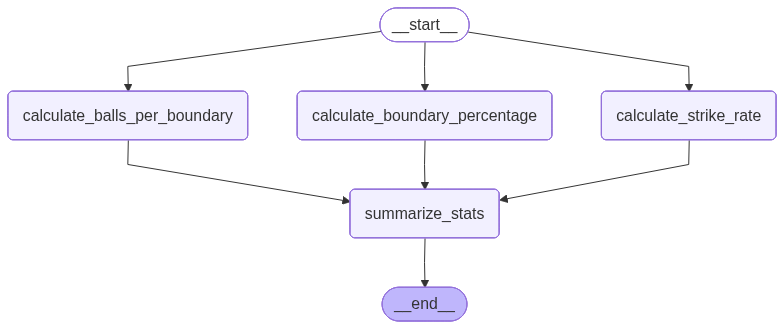

In [18]:
graph = StateGraph(BatterState)

graph.add_node("calculate_strike_rate", calc_sr)
graph.add_node("calculate_boundary_percentage", calc_boundary_pct)
graph.add_node("calculate_balls_per_boundary", calc_bpb)
graph.add_node("summarize_stats", summarize_stats)

graph.add_edge(START, "calculate_strike_rate")
graph.add_edge(START, "calculate_boundary_percentage")
graph.add_edge(START, "calculate_balls_per_boundary")
graph.add_edge("calculate_strike_rate", "summarize_stats")
graph.add_edge("calculate_boundary_percentage", "summarize_stats")
graph.add_edge("calculate_balls_per_boundary", "summarize_stats")
graph.add_edge("summarize_stats", END)

cric_stats = graph.compile()
cric_stats

In [21]:
inial_state = {"runs": 300, "balls": 150, "num_4s": 20, "num_6s": 10,}
output_state = cric_stats.invoke(inial_state)

print("Final Batter Stats:", output_state['summary'])

Final Batter Stats: 
    Strike Rate: 200.0
    Boundary Percentage: 46.67
    Balls per Boundary: 5.0 


## LLM based parallel workflow

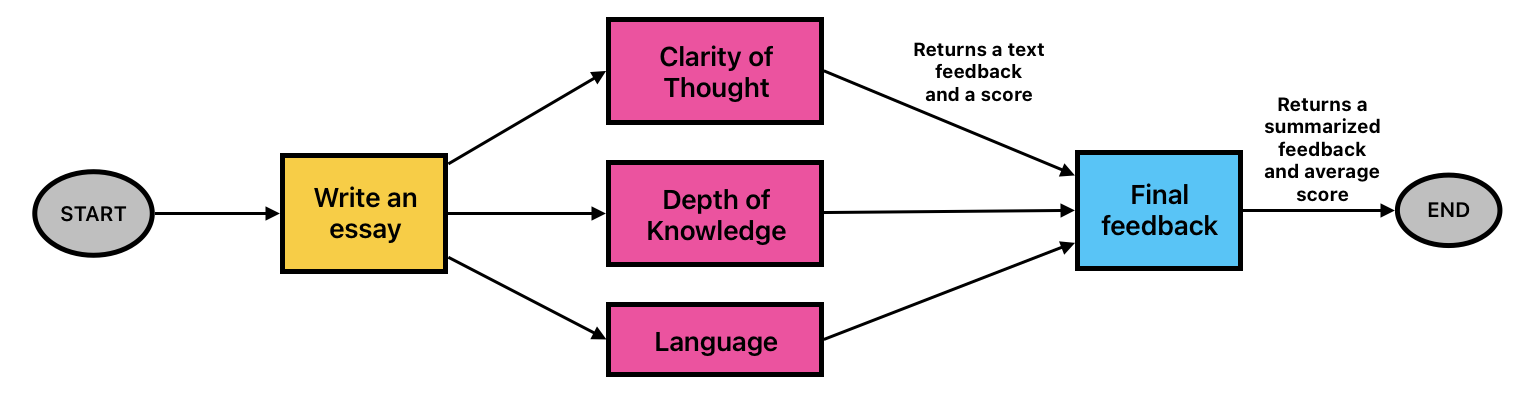

In [31]:
class EvalSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Score out of 10", ge=0, le=10)

class EssayEvalState(TypedDict):
    topic: str
    content: str

    clarity_feedback: str # clarity of thought
    knowledge_depth_feedback: str
    language_feedback: str
    overall_feedback: str

    # we will have to use a reducer function (here .concat) to avoid overwriting of the scores
    individual_scores: Annotated[list[float], operator.concat] # [clarity_score, knowledge_depth_score, language_score]
    
    overall_score: float

LLM = ChatGroq(model="llama-3.1-8b-instant")
Struct_LLM = LLM.with_structured_output(EvalSchema)

In [36]:
def gen_essay(state: EssayEvalState) -> EssayEvalState:
    prompt = f""" Generate a detailed essay on the topic - {state['topic']} """
    content = LLM.invoke(prompt).content
    return {'content': content}

def eval_clarity(state: EssayEvalState) -> EssayEvalState:
    prompt = f""" You are an expert essay evaluator.
        On the basis of clarity of thought in the essay, evaluate it and give a short feedback and a score out of 10.
        Topic: {state['content']}
        Essay: {state['content']}
    """
    out = Struct_LLM.invoke(prompt).model_dump()
    return {"clarity_feedback": out['feedback'], "individual_scores": [out['score']]}

def eval_knowledge_depth(state: EssayEvalState) -> EssayEvalState:
    prompt = f""" You are an expert essay evaluator.
        On the basis of depth of knowledge in the essay, evaluate it and give a short feedback and a score out of 10.
        Topic: {state['content']}
        Essay: {state['content']}
    """
    out = Struct_LLM.invoke(prompt).model_dump()
    return {"knowledge_depth_feedback": out['feedback'], "individual_scores": [out['score']]}

def eval_language(state: EssayEvalState) -> EssayEvalState:
    prompt = f""" You are an expert essay evaluator.
        On the basis of language quality in the essay, evaluate it and give a short feedback and a score out of 10.
        Topic: {state['content']}
        Essay: {state['content']}
    """
    out = Struct_LLM.invoke(prompt).model_dump()
    return {"language_feedback": out['feedback'], "individual_scores": [out['score']]}

def eval_overall(state: EssayEvalState) -> EssayEvalState:
    prompt = f""" You are an expert summarizer.
        Summarize the feedbacks given about the essay.
        Language quality feedback: {state['language_feedback']}
        Depth of knowledge feedback: {state['knowledge_depth_feedback']}
        Clarity of thought feedback: {state['clarity_feedback']}
    """
    feedback = LLM.invoke(prompt).content
    all_scores = state['individual_scores']
    score = round(sum(all_scores) / len(all_scores), 2)
    return {"overall_feedback": feedback, "overall_score": score}

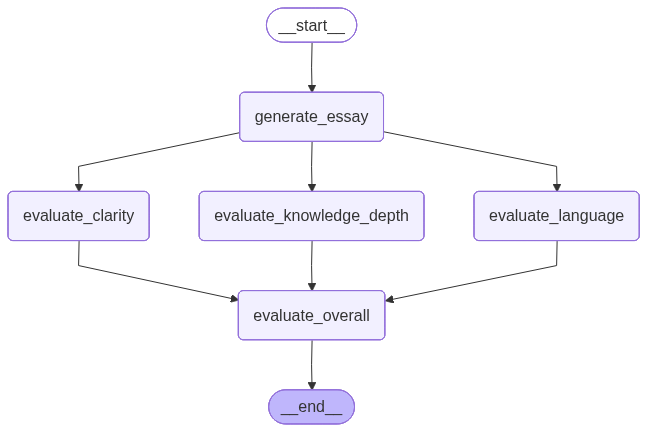

In [ ]:
graph = StateGraph(EssayEvalState)

# nodes
graph.add_node("generate_essay", gen_essay)
graph.add_node("evaluate_clarity", eval_clarity)
graph.add_node("evaluate_knowledge_depth", eval_knowledge_depth)
graph.add_node("evaluate_language", eval_language)
graph.add_node("evaluate_overall", eval_overall)

# edges
graph.add_edge(START, "generate_essay")

graph.add_edge("generate_essay", "evaluate_clarity")
graph.add_edge("generate_essay", "evaluate_knowledge_depth")
graph.add_edge("generate_essay", "evaluate_language")

graph.add_edge("evaluate_clarity", "evaluate_overall")
graph.add_edge("evaluate_knowledge_depth", "evaluate_overall")
graph.add_edge("evaluate_language", "evaluate_overall")

graph.add_edge("evaluate_overall", END)

# compile
eval_essay_flow = graph.compile()
eval_essay_flow

In [38]:
initial_state = {"topic": "Rising trends of AI in India"}
output_state = eval_essay_flow.invoke(initial_state)

In [39]:
output_state

{'topic': 'Rising trends of AI in India',
 'content': '**The Rising Trends of AI in India: A Revolutionary Shift in the Technological Landscape**\n\nIn recent years, India has witnessed a remarkable surge in the adoption and implementation of Artificial Intelligence (AI) across various sectors, including healthcare, finance, education, and transportation. The country\'s rapidly growing economy, large workforce, and increasing digital penetration have created a favorable environment for the proliferation of AI. As a result, India is emerging as a global hub for AI innovation and adoption, with numerous startups, corporations, and government initiatives driving this technological revolution.\n\n**Government Support and Initiatives**\n\nThe Indian government has taken significant steps to promote the development and deployment of AI in the country. In 2017, the government launched the "Digital India" initiative, which aimed to harness the power of technology to transform India into a digi